In [73]:
import torch 
from torch.distributions import Normal
import matplotlib.pyplot as plt

In [244]:
def fisher_info(p):
    var = p.variance
    F = torch.eye(2)
    F[0,0] = 1/var 
    F[1,1] = 2/var
    return F

def fisher_info_mc(theta_0, N=100000):
    theta_0_help = theta_0.clone().repeat(N,1).requires_grad_(True)
    prob = p(theta_0_help)
    samples = prob.sample((1,))
    log_probs = prob.log_prob(samples)
    score = torch.autograd.grad(log_probs.sum(), theta_0_help)[0]
    return torch.mean(score.unsqueeze(2)@score.unsqueeze(1), axis=0)

In [245]:
theta_0 = torch.tensor([[0., 4.]])
fisher_info_mc(theta_0)

tensor([[ 0.0624, -0.0011],
        [-0.0011,  0.1242]])

In [246]:
fisher_info(p(theta_0))

tensor([[0.0625, 0.0000],
        [0.0000, 0.1250]])

In [321]:
def p(theta):
    return Normal(theta[:,0], theta[:,1].abs())

In [322]:
theta_0 = torch.tensor([[0., 4.]])

s = 0.1
perturbed = theta_0 + torch.randn(1000000, 2)*s

In [323]:
def eval_kl(thetas, theta_0):
    p1 = p(theta_0)
    p2 = p(thetas)
    return torch.distributions.kl_divergence(p1, p2)


In [324]:
m = eval_kl(perturbed, theta_0).mean()
m

tensor(0.0009)

In [325]:
s**2*torch.trace(fisher_info(p(theta_0)))

tensor(0.0019)

In [467]:
theta_0 = torch.tensor([[0., 5.]])
scales = torch.linspace(0.001, 1, 1000)
kls_mean = []
kls_mean_estimate = []

for s in scales:
    perturbed = theta_0 + torch.randn(10000, 2)*s
    kls_mean.append(eval_kl(perturbed, theta_0).mean())
    kls_mean_estimate.append(0.5*s**2*torch.trace(fisher_info(p(theta_0))))

Text(0.5, 0, 'Variance of $\\delta$')

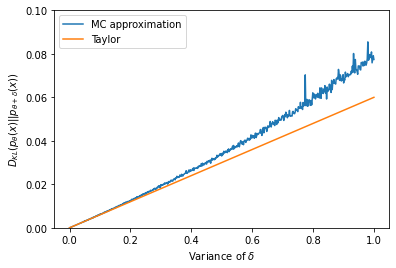

In [469]:
plt.plot(scales**2, kls_mean)
plt.plot(scales**2, kls_mean_estimate)
plt.ylim(0,0.1)
plt.legend(["MC approximation", "Taylor"])
plt.ylabel(r"$D_{KL}(p_\theta (x)|| p_{\theta + \delta}(x))$")
plt.xlabel("Variance of $\delta$")

In [ ]:
# So the taylor approximations is actually pretty good in this Gaussian case...

In [750]:
A = torch.randn((2,2))
def f(x):
    y = (A@x.T).T
    y[:,1] = y[:,1].exp()
    return y


In [660]:
f = torch.nn.Sequential(torch.nn.Linear(2, 10), torch.nn.ReLU(), torch.nn.Linear(10, 10), torch.nn.Linear(10, 2), torch.nn.Sigmoid())

In [751]:
def batch_jacobian(func, x, create_graph=False):
  # x in shape (Batch, Length)
  def _func_sum(x):
    return func(x).sum(dim=0)
  return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

In [662]:
x_0 = torch.tensor([[2.,2.]])
s = 0.1
perturbed = x_0 + torch.randn(1000000, 2)*s

In [663]:
m = eval_kl(f(perturbed), f(x_0)).mean()
m

tensor(5.0363e-06, grad_fn=<MeanBackward0>)

In [752]:
J = batch_jacobian(f, x_0)[0]

In [665]:
J@J.T

tensor([[ 7.0413e-07, -1.0165e-05],
        [-1.0165e-05,  1.4733e-04]])

In [666]:
0.5*s**2*torch.trace(fisher_info(p(f(x_0)))@J@J.T)

tensor(5.0452e-06, grad_fn=<MulBackward0>)

In [667]:
0.5*s**2*torch.trace(fisher_info(p(f(x_0))))

tensor(0.0512, grad_fn=<MulBackward0>)

In [668]:
x_0 = torch.tensor([[2.,2.]])
scales = torch.linspace(0.001, 1, 1000)
kls_mean = []
kls_mean_estimate = []
J = batch_jacobian(f, x_0)[0]
for s in scales:
    perturbed = x_0 + torch.randn(100000, 2)*s
    theta_0 = f(x_0)
    perturbed = f(perturbed)
    kls_mean.append(eval_kl(perturbed, theta_0).mean().detach())
    kls_mean_estimate.append(0.5*s**2*torch.trace(fisher_info(p(theta_0))@J@J.T).detach())

Text(0.5, 0, 'Variance of $\\delta$')

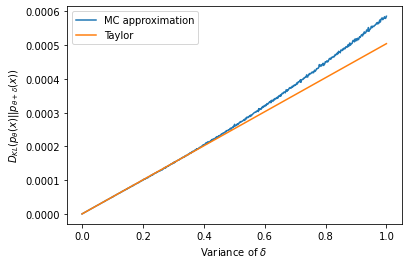

In [669]:
plt.plot(scales**2, kls_mean)
plt.plot(scales**2, kls_mean_estimate)
plt.legend(["MC approximation", "Taylor"])
plt.ylabel(r"$D_{KL}(p_\theta (x)|| p_{\theta + \delta}(x))$")
plt.xlabel("Variance of $\delta$")

In [779]:
vs = torch.randn((10000, 2))
vs /= torch.linalg.norm(vs, dim=0)


In [792]:
(vs.unsqueeze(2)@vs.unsqueeze(1)).mean(0)

tensor([[ 1.0000e-04, -5.1312e-07],
        [-5.1312e-07,  1.0000e-04]])

In [757]:
eps = 0.00001
directional_derivative = (f(x_0 + eps*v) - f(x_0))/eps

In [760]:
directional_derivative

tensor([[ 1.1563, -0.0864]])

In [761]:
J@v.T

tensor([[ 1.1506],
        [-0.0871]])